# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:56<00:00, 1560.08it/s]


In [23]:
final['Cleaned Text'] = preprocessed_reviews

In [24]:
sample1 = pd.DataFrame()

In [25]:
sample1['Cleaned Text'] =preprocessed_reviews

In [26]:
sample1.tail(3)

,Cleaned Text
87770,trader joe product good quality buy straight t...
87771,coffee supposedly premium tastes watery thin n...
87772,purchased product local store ny kids love qui...


In [27]:
k1 = []

In [28]:
sample1.shape

(87773, 1)

In [29]:
for i in range(0,87773):
    k1.append(len(preprocessed_reviews[i]))

In [30]:
sample1['Length'] = k1

In [31]:
sample1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Splitting the Data with feature engineering

In [33]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(sample1,final['Score'].values,test_size=0.3,shuffle=False)

In [34]:
y_train1.shape

(61441,)

In [35]:
X_train1.shape

(61441, 2)

In [36]:
X_test1.shape

(26332, 2)

In [37]:
type(y_test1)

numpy.ndarray

In [38]:
type(X_test1)

pandas.core.frame.DataFrame

In [39]:
X_train1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


In [40]:
X_test1.head(3)

,Cleaned Text,Length
61441,used treat training reward dog loves easy brea...,66
61442,much fun watching puppies asking chicken treat...,134
61443,little shih tzu absolutely loves cesar softies...,181


In [41]:
X_trainbow = pd.DataFrame()

In [42]:
X_trainbow['Cleaned Text'] = X_train1['Cleaned Text'] 

In [43]:
X_trainbow.head(3)

,Cleaned Text
0,dogs loves chicken product china wont buying a...
1,dogs love saw pet store tag attached regarding...
2,infestation fruitflies literally everywhere fl...


In [44]:
X_testbow = pd.DataFrame()

In [45]:
X_testbow['Cleaned Text'] = X_test1['Cleaned Text']

In [47]:
X_testbow.head(3)

,Cleaned Text
61441,used treat training reward dog loves easy brea...
61442,much fun watching puppies asking chicken treat...
61443,little shih tzu absolutely loves cesar softies...


# BAG OF WORDS WITH FEATURE ENGINEERING 

In [48]:
X_trainbow.shape

(61441, 1)

In [49]:
X_testbow.shape

(26332, 1)

In [50]:
count_vect = CountVectorizer() 
a1 = count_vect.fit_transform(X_trainbow['Cleaned Text'].values)
b1 = count_vect.transform(X_testbow['Cleaned Text'])

In [51]:
print("the type of count vectorizer :",type(a1))
print("the shape of out text BOW vectorizer : ",a1.get_shape())
print("the number of unique words :", a1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (61441, 46008)
the number of unique words : 46008


# ADDING LENGTH OF REVIEWS AS ONE FEATURE 

In [52]:
a1 = preprocessing.normalize(a1)

In [53]:
from scipy import sparse

In [54]:
from scipy.sparse import csr_matrix

In [55]:
a2 = sparse.csr_matrix(X_train1['Length'].values)

In [56]:
a2 = preprocessing.normalize(a2)

In [57]:
a1

<61441x46008 sparse matrix of type '<class 'numpy.float64'>'
	with 2002037 stored elements in Compressed Sparse Row format>

In [58]:
a2.T

<61441x1 sparse matrix of type '<class 'numpy.float64'>'
	with 61271 stored elements in Compressed Sparse Column format>

In [59]:
a3 = sparse.hstack([a1, a2.T])

In [60]:
a3.shape

(61441, 46009)

In [61]:
b1 = preprocessing.normalize(b1)

In [62]:
b2 = sparse.csr_matrix(X_test1['Length'].values)

In [63]:
b2 = preprocessing.normalize(b2)

In [64]:
b1

<26332x46008 sparse matrix of type '<class 'numpy.float64'>'
	with 888781 stored elements in Compressed Sparse Row format>

In [65]:
b2.T

<26332x1 sparse matrix of type '<class 'numpy.float64'>'
	with 26286 stored elements in Compressed Sparse Column format>

In [66]:
b3 = sparse.hstack([b1, b2.T])

In [67]:
a3.shape

(61441, 46009)

In [122]:
b3.shape

(26332, 46009)

In [69]:
y_test1.shape

(26332,)

In [121]:
y_train1.shape

(61441,)

# Logistic Regression for BOW with Feature Engineering

In [71]:
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

# L2 REGULARISATION

In [123]:
#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model1 = GridSearchCV(LogisticRegression(class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv=5, return_train_score= True)
model1.fit(a3, y_train1)
print(model1.best_estimator_)
print(model1.score(b3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9490679045177951


# L1 REGULARISATION 

In [124]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]

# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv=5, return_train_score = True)
model.fit(a3, y_train1)
print(model.best_estimator_)
print(model.score(b3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9500053287544736


# Observations for Logistic Regression (BOW) (BOTH L1 AND L2) 

1) We found that with L2 REGULARISER THE optimum c is 1 and the best  score was 0.949
 
2) With L1 REGULARISATION TOO THE OPTIMUM C IS 1. 

3) We found that L1 is better than L2 slightly.

In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Running the Model with Optimal C and L1 regularisation

In [73]:
from sklearn.metrics import roc_auc_score

In [125]:
alph1 = [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]

In [126]:
model.cv_results_

{'mean_fit_time': array([0.08266292, 0.09372878, 0.29012675, 0.68707824, 1.769346  ,
        2.01248002, 1.12386308]),
 'std_fit_time': array([8.45582399e-03, 3.20582129e-06, 2.85730244e-02, 3.51254491e-02,
        5.91012298e-02, 1.23447958e-01, 5.29811604e-02]),
 'mean_score_time': array([0.006846  , 0.        , 0.00418916, 0.00179505, 0.00219207,
        0.00392156, 0.0045198 ]),
 'std_score_time': array([0.00724591, 0.        , 0.00040095, 0.00222071, 0.00182659,
        0.0060496 , 0.0057745 ]),
 'param_C': masked_array(data=[1e-05, 0.0001, 0.01, 1, 100, 10000, 100000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.01},
  {'C': 1},
  {'C': 100},
  {'C': 10000},
  {'C': 100000}],
 'split0_test_score': array([0.5       , 0.5       , 0.77091467, 0.94435936, 0.89845904,
        0.8751227 , 0.84881126]),
 'split1_test_score': array([0.5       , 0.5       , 0.

In [78]:
train_auc= model.cv_results_['mean_train_score']
cv_auc= model.cv_results_['mean_test_score']

In [79]:
train_auc1= model1.cv_results_['mean_train_score']
cv_auc1= model1.cv_results_['mean_test_score']

In [80]:
train_auc1

array([0.78373149, 0.78622319, 0.86606284, 0.96677728, 0.9970892 ,
       0.99998889, 0.99999724])

In [81]:
cv_auc1

array([0.77980099, 0.78219249, 0.85854813, 0.94386418, 0.9318972 ,
       0.89148987, 0.88467314])

In [82]:
train_auc

array([0.5       , 0.5       , 0.76796783, 0.96421071, 0.99985648,
       0.99999725, 0.99999725])

In [83]:
cv_auc

array([0.5       , 0.5       , 0.76602852, 0.94476225, 0.90027524,
       0.8802149 , 0.85237726])

In [74]:
import math
from math import log

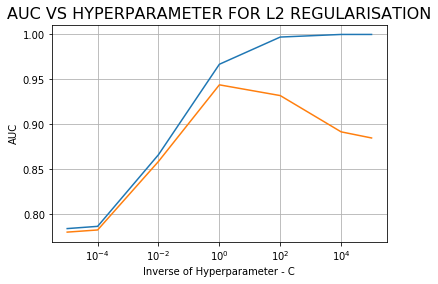



 Alpha values :
 [1e-05, 0.0001, 0.01, 1, 100, 10000, 100000]

 Train AUC for each alpha value is :
  [0.78373 0.78622 0.86606 0.96678 0.99709 0.99999 1.     ]

 CV AUC for each alpha value is :
  [0.7798  0.78219 0.85855 0.94386 0.9319  0.89149 0.88467]


In [85]:
# This is just for my reference - I am trying to plot both for L1 and L2 REGULARISER
# hERE IT IS FOR L2 REGULARISER
plt.plot(alph1,train_auc1)
plt.plot(alph1,cv_auc1)
plt.xlabel('Inverse of Hyperparameter - C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER FOR L2 REGULARISATION',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha values :\n", alph1)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc1,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc1,5))

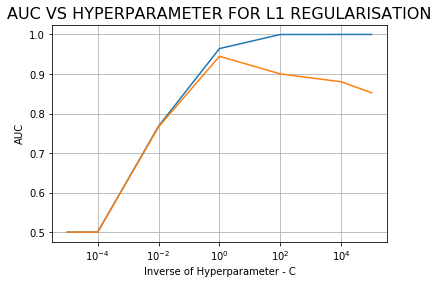



 Alpha values :
 [1e-05, 0.0001, 0.01, 1, 100, 10000, 100000]

 Train AUC for each alpha value is :
  [0.5     0.5     0.76797 0.96421 0.99986 1.      1.     ]

 CV AUC for each alpha value is :
  [0.5     0.5     0.76603 0.94476 0.90028 0.88021 0.85238]


In [86]:
# plot accuracy vs alpha 
plt.plot(alph1,train_auc)
plt.plot(alph1,cv_auc)
plt.xlabel('Inverse of Hyperparameter - C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER FOR L1 REGULARISATION',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha values :\n", alph1)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc,5))

# Observations

1) We have found that the optimal C  occurs at 1 as the cv accuracy is high at that point for both L1 and L2.

In [87]:
optimalalpha2_bow = 1
auc_bow = max(cv_auc)
auc_bow1 = max(cv_auc1)

In [88]:
from IPython.display import HTML, display
import tabulate
table = [["Vectorizer","Model","Regularisation","Hyperparameter","AUC"],
         ["BOW", "Logistic Regression ", "L1 " ,optimalalpha2_bow, np.round(auc_bow,4) ],
         ["BOW", "Logistic Regression ", "L2 " ,optimalalpha2_bow, np.round(auc_bow1,4)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Vectorizer,Model,Regularisation,Hyperparameter,AUC
BOW,Logistic Regression,L1,1,0.9448
BOW,Logistic Regression,L2,1,0.9439


In [90]:
# after you found the best hyper parameter, you need to train your model with it, 
#and find the AUC on test data and plot the ROC curve on both train and test. 
# Along with plotting ROC curve, you need to print the confusion matrix with predicted 
#and original labels of test data points. Please visualize your confusion matrices using seaborn heatmaps. 

# Training the model with the best hyper parameter 

In [127]:
om_bow = LogisticRegression(C = 1 , penalty = 'l1' , class_weight = 'balanced')

In [128]:
#om_bow = MultinomialNB(alpha = optimalalpha2_bow)
# fitting the model and predicting the responses
om_bow.fit(a3, y_train1)
ompredictions_bow  = om_bow.predict(b3)

In [129]:
len(ompredictions_bow)

26332

In [130]:
len(y_test1)

26332

In [131]:
probs = om_bow.predict_proba(b3)

In [132]:
probs1 = om_bow.predict_proba(a3)

In [133]:
len(probs1)

61441

In [134]:
len(probs)

26332

In [135]:
probs = probs[:, 1]

In [136]:
probs1 = probs1[:, -1]

# FEATURE IMPORTANCE  FOR BOW 

In [101]:
om_bow.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)>

In [102]:
count_vect.get_params

<bound method BaseEstimator.get_params of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [137]:
features = count_vect.get_feature_names()

In [138]:
Coefficients = om_bow.coef_[0]

In [105]:
len(features)
features.append('zzzzzzzzzza')

In [106]:
len(features)

46009

In [139]:
coef = Coefficients

In [108]:
cf = pd.DataFrame({'Word' : features, 'Coefficient' : Coefficients})
cf_new = cf.sort_values("Coefficient", ascending = False)
print('***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****')
print('\n')
print(cf_new.head(10))
print('\n')
print('***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****')
print('\n')
print(cf_new.tail(10))

***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****


             Word  Coefficient
30411  pleasantly    15.503561
19188      hooked    11.330013
10560   delicious    10.827128
3391         beat    10.672516
45829       yummy    10.645699
8225    complaint    10.211309
2762      awesome     9.742074
45797         yum     9.696419
35114   satisfied     9.654699
1285      amazing     9.644375


***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****


                 Word  Coefficient
11574      disgusting   -10.663955
34257             rip   -10.835473
5763         canceled   -11.059954
41905           trash   -11.218602
40533        terrible   -11.726037
5766        cancelled   -11.859516
19207           hopes   -12.392379
11444  disappointment   -12.766767
11442   disappointing   -14.818483
45296           worst   -18.515108


# Observations :
1) We have found that pleasantly and hooked are the top 2 words that influences the positive class.

2) We have found that worst and the disappointing are the top 2 words that influences the neagative class. 

# Pertubation Test 

In [140]:
from scipy.sparse import find
# OLD COEFFICIENTS
old_coef = om_bow.coef_[0]
w_coef1 = old_coef[np.nonzero(old_coef)]
print(w_coef1[:25])

[ 2.58630232  1.37180366  1.42565548 -0.73121525  0.91877654 -1.58608666
  0.8360767  -0.2916829   4.37558997  0.0241404   0.80723978  5.59328376
  4.79488589  3.48302139  7.42767805  1.54287792  0.63039365  3.25218314
  0.90448357 -0.91686193  5.75879313  2.74630744 -1.24343087  0.10072506
 -1.47284846]


In [141]:
len(old_coef)

46009

In [142]:
a3

<61441x46009 sparse matrix of type '<class 'numpy.float64'>'
	with 2063308 stored elements in COOrdinate format>

In [143]:
a3_modified = a3.todense()

In [144]:
a3_modified[5] = a3_modified[5] + 0.000001

In [145]:
om_bow_new = LogisticRegression( C= 1,class_weight = 'balanced', penalty = 'l1')

In [146]:
om_bow_new.fit(a3_modified, y_train1)
#ompredictions_bow  = om_bow.predict(b3)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [147]:
new_coef = om_bow_new.coef_[0]

In [118]:
# new_coef is the new weights obtained for the noise data. 
# old_coef is the old weights obtained for the original data.
# Now I am going to find the percentage change in Weights. However there are many zero's in the weight vectors. 
# FOR AVOIDING DIVISON BY ZERO ERROR I AM ADDING SMALL VALUES LIKE 10^-6 TO BOTH WEIGHT VECTORS.

In [148]:
old_coef = old_coef + 0.000003
new_coef = new_coef + 0.000003

In [149]:
diff_coef = new_coef - old_coef

In [150]:
delta_coef = diff_coef / old_coef

In [151]:
type(delta_coef)

numpy.ndarray

In [152]:
delta_coef[1:6]

array([0., 0., 0., 0., 0.])

In [ ]:
# Sorting the array in ascending order

In [157]:
delta_coef1 = delta_coef

In [159]:
delta_coef1 = abs(delta_coef1)

In [160]:
dc2 = np.sort(delta_coef1)

In [161]:
dc2 = dc2*100

In [162]:
dc2[1:6]

array([0., 0., 0., 0., 0.])

In [163]:
max(dc2)

376.13373456448153

In [165]:
for i in range(10,110,10):
    p = np.percentile(dc2, i) # return bth percentile.
    print("The : % 3d percentile is : % 2d" %(i, p)) 

The :  10 percentile is :  0
The :  20 percentile is :  0
The :  30 percentile is :  0
The :  40 percentile is :  0
The :  50 percentile is :  0
The :  60 percentile is :  0
The :  70 percentile is :  0
The :  80 percentile is :  0
The :  90 percentile is :  0
The :  100 percentile is :  376


# Observations

The above result implies that there are no many changes in the weights even with noise. 

Hence we can conclude that maximum are non collinear.

In [167]:
for i in range(90,101):
    p = np.percentile(dc2, i) # return bth percentile.
    print("The  % 3d percentile is : % 2d" %(i, p)) 

The   90 percentile is :  0
The   91 percentile is :  0
The   92 percentile is :  0
The   93 percentile is :  0
The   94 percentile is :  0
The   95 percentile is :  0
The   96 percentile is :  0
The   97 percentile is :  0
The   98 percentile is :  0
The   99 percentile is :  0
The   100 percentile is :  376


In [172]:
w123 = dc2[np.nonzero(dc2)]
print(w123[:25])

[1.61799893e-06 4.24790496e-06 6.11605834e-06 7.62730197e-06
 7.74157847e-06 8.66284769e-06 9.94869955e-06 1.14847284e-05
 1.14972509e-05 1.17835492e-05 1.21933856e-05 1.25637626e-05
 1.33311533e-05 2.30494874e-05 2.31202053e-05 2.39833253e-05
 2.77156135e-05 2.94851341e-05 3.07637229e-05 3.16205515e-05
 3.17243646e-05 3.19128680e-05 3.34617720e-05 3.39997751e-05
 3.54703025e-05]


In [186]:
w123 = w123 * 100

In [187]:
w123[1:3]

array([0.00042479, 0.00061161])

In [188]:
min(w123),max(w123)

(0.00016179989300771878, 37613.37345644816)

In [189]:
for i in range(10,110,10):
    p = np.percentile(w123, i) # return bth percentile.
    print("The : % 3d percentile is : % 2d" %(i, p)) 

The :  10 percentile is :  0
The :  20 percentile is :  0
The :  30 percentile is :  0
The :  40 percentile is :  0
The :  50 percentile is :  0
The :  60 percentile is :  0
The :  70 percentile is :  0
The :  80 percentile is :  1
The :  90 percentile is :  2
The :  100 percentile is :  37613


In [190]:
for i in range(90,101,1):
    p = np.percentile(w123, i) # return bth percentile.
    print("The : % 3d percentile is : % 2d" %(i, np.round(p,7))) 

The :  90 percentile is :  2
The :  91 percentile is :  2
The :  92 percentile is :  3
The :  93 percentile is :  3
The :  94 percentile is :  4
The :  95 percentile is :  5
The :  96 percentile is :  7
The :  97 percentile is :  10
The :  98 percentile is :  14
The :  99 percentile is :  33
The :  100 percentile is :  37613


In [192]:
# We found that there is a sudden rise in the value from 99th percentile to 100th percentile.
# Hence I am considering the floating percentiles.

In [197]:
b123 = 99.1

for i in range(0,10):
    p = np.percentile(w123, b123)
    print("The : % 3f percentile is : % 2d" %(b123 , np.round(p,7))) 
    b123 = b123 + 0.1 

The :  99.100000 percentile is :  42
The :  99.200000 percentile is :  50
The :  99.300000 percentile is :  62
The :  99.400000 percentile is :  82
The :  99.500000 percentile is :  119
The :  99.600000 percentile is :  131
The :  99.700000 percentile is :  304
The :  99.800000 percentile is :  445
The :  99.900000 percentile is :  4831
The :  100.000000 percentile is :  37613


# Observations :

1) AFTER 99.6 PERCENTILE THERE IS HUGE RISE FROM 131 TO 304.  
2) Hence the threshold value is 304 now.

In [199]:
max(delta_coef)

3.761337345644815

In [134]:
#delta_coef1 = delta_coef[::-1].sort()

In [200]:
dc1 = -np.sort(-delta_coef)

In [201]:
dc1 = dc1*100

In [202]:
dc1

array([376.13373456,  23.47031277,   2.9559747 , ...,  -3.58095283,
        -4.73332921, -89.0140016 ])

In [203]:
dc1[0:5]

array([376.13373456,  23.47031277,   2.9559747 ,   1.38582639,
         1.2394528 ])

In [204]:
dc1[4:14]

array([1.2394528 , 1.19301763, 1.16555094, 0.64312315, 0.43285265,
       0.33750781, 0.30089797, 0.29326849, 0.1773409 , 0.14166514])

In [205]:
iteration_number = [i for i in range (1,len(delta_coef)+1)]

In [206]:
len(iteration_number)

46009

In [207]:
len(w123)

1622

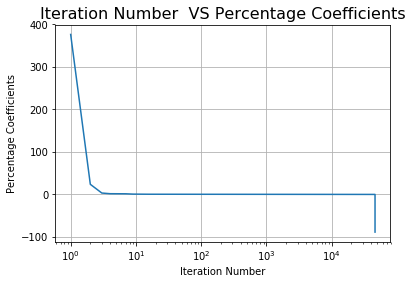

In [208]:
plt.plot(iteration_number,dc1)
#plt.plot(alph1,cv_auc)
plt.ylabel('Percentage Coefficients',size=10)
plt.xlabel('Iteration Number',size=10)
plt.title('Iteration Number  VS Percentage Coefficients',size=16)
plt.xscale('log')
plt.grid()
plt.show()

In [209]:
max(delta_coef)

3.761337345644815

# Observations - > Pertubation Test

1) We observe that for only one feature the percentage difference is higher than our threshhold value.

2) Hence I can conclude that maximum of the features are non collinear. There are only few features which are collinear to some 
    extent. If i choose the threshold value as 1.5% , we observe that 3 variables are collinear. 
    
3) FINAL CONCLUSION - from pertubation test is - > As the weights does not chnage by a larger percentage, the features are non-collinear.


# PERFORMANCE MEASURMENTS  FOR BOW ( LOGISTIC REGRESSION)

In [170]:
precision_bow = precision_score(y_test1, ompredictions_bow, pos_label = 1) 
recall_bow = recall_score(y_test1, ompredictions_bow, pos_label = 1) 
f1score_bow = f1_score(y_test1, ompredictions_bow, pos_label = 1) 

In [171]:
print('\nThe Test Precision for optimal alpha for Logistic Regression (BOW)   is %f' % (precision_bow))
print('\nThe Test Recall for optimal alpha for Logistic Regression (BOW)  is %f' % (recall_bow))
print('\nThe Test F1-Score for optimal alpha for Logistic Regression (BOW)  is %f' %  (f1score_bow))


The Test Precision for optimal alpha for Logistic Regression (BOW)   is 0.974156

The Test Recall for optimal alpha for Logistic Regression (BOW)  is 0.869565

The Test F1-Score for optimal alpha for Logistic Regression (BOW)  is 0.918894


# CONFUSION MATRIX 

In [132]:
# Reference Links 
# https://datatofish.com/confusion-matrix-python/

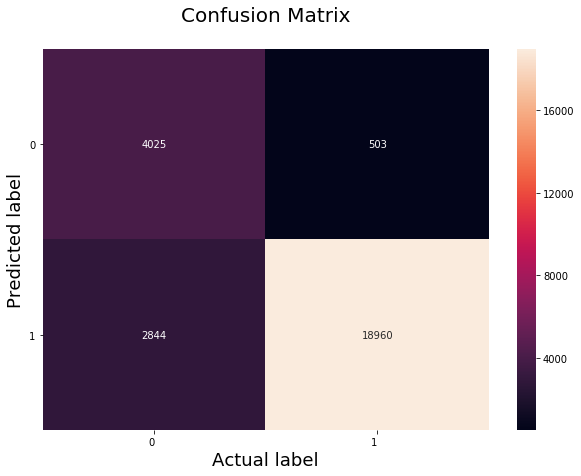

In [172]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_bow), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()

In [173]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_bow).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)

In [174]:
print("TPR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  %f" % (TPR))
print("FPR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  %f" % (FPR))
print("TNR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  %f" % (TNR))
print("FNR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  %f" % (FNR))

TPR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  0.974156
FPR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  0.414034
TNR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  0.585966
FNR of the Multinomial naive Bayes classifier (BOW) for alpha  is :  0.025844


# PLOTTING THE ROC CURVE  (BOW) ---- > FOR BOTH TRAIN AND TEST DATA 

In [175]:
len(y_train1)

61441

In [176]:
len(probs1)

61441

In [177]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

#for i in range(26331):
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#for i in range(61441):
for i in range(4):    
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs1)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    

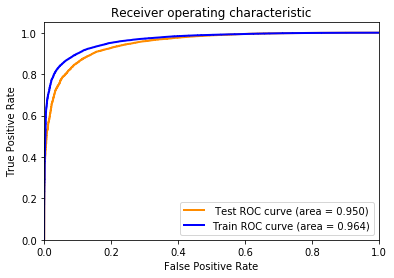

In [179]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.3f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations 
1) We observe that AUC for test data is 0.95 and train data is 0.96 which implies that the model is very good.

# TFIDF WITH FEATURE ENGINEERING 

In [90]:
tf_idf_vect = TfidfVectorizer(min_df=10)
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(X_testbow['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (61441, 9723)
the number of unique words : 9723


In [91]:
c1 = preprocessing.normalize(c1)

In [92]:
c2 = sparse.csr_matrix(X_train1['Length'].values)
c2 = preprocessing.normalize(c2)

In [93]:
c1

<61441x9723 sparse matrix of type '<class 'numpy.float64'>'
	with 1925265 stored elements in Compressed Sparse Row format>

In [94]:
c2.T

<61441x1 sparse matrix of type '<class 'numpy.float64'>'
	with 61271 stored elements in Compressed Sparse Column format>

In [95]:
c3 = sparse.hstack([c1, c2.T])

In [96]:
d1 = preprocessing.normalize(d1)
d2 = sparse.csr_matrix(X_test1['Length'].values)
d2 = preprocessing.normalize(d2)
d3 = sparse.hstack([d1, d2.T])

# L1 REGULARISATION - TFIDF

In [190]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]

# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv=5, return_train_score = True)
model.fit(c3, y_train1)
print(model.best_estimator_)
print(model.score(d3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9509492252855993


# L2 REGULARISATION - TFIDF

In [195]:
#tuned_parameters = [{'C': [10**-1,10**0, 10]}]
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]

# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv=5, return_train_score = True)
model.fit(c3, y_train1)
print(model.best_estimator_)
print(model.score(d3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9515943783291295


# Observations :

1) Throogh L1 regularisation and L2 regularisation we observed that the optimal C is at 1.

2) However the accuracy is slightly better in L2 ( 0.952) than in L1 (0.951). 

# OPTIMAL ALPHA FOR TFIDF - THROUGH PLOTTING APPROACH 

In [196]:
train_auc_tfidf = model.cv_results_['mean_train_score']
cv_auc_tfidf = model.cv_results_['mean_test_score']

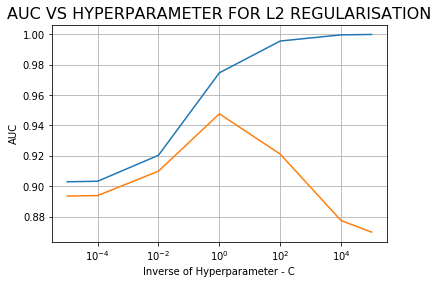



 Alpha values :
 [1e-05, 0.0001, 0.01, 1, 100, 10000, 100000]

 Train AUC for each alpha value is :
  [0.90288 0.90321 0.92032 0.97457 0.99549 0.99953 0.99982]

 CV AUC for each alpha value is :
  [0.89347 0.89379 0.90986 0.94759 0.92107 0.87734 0.86974]


In [197]:
plt.plot(alph1,train_auc_tfidf)
plt.plot(alph1,cv_auc_tfidf)
plt.xlabel('Inverse of Hyperparameter - C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER FOR L2 REGULARISATION',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha values :\n", alph1)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc_tfidf,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc_tfidf,5))

# Observations :

1) We found that optimal value for C is 1 as the cv accuracy is highest for that point.

In [200]:
auc_tfidf = max(cv_auc_tfidf)
auc_tfidf

0.9475897505932972

# Training the model with the best hyper parameter for TFIDF 

In [201]:
om_tfidf = LogisticRegression(C = 1 , penalty = 'l2' , class_weight = 'balanced')

In [202]:
om_tfidf.fit(c3, y_train1)
ompredictions_tfidf  = om_tfidf.predict(d3)
# Checking the test accuracy
#tesacc_tfidf   = accuracy_score(y_test1, ompredictions_tfidf) * 100
#res_tesaccuracy.append(tesacc_tfidf)

In [203]:
probs2 = om_tfidf.predict_proba(c3)
probs3 = om_tfidf.predict_proba(d3)
probs2= probs2[:, 1]
probs3 = probs3[:, 1]

# Feature  Importance for TFIDF 

In [205]:
features = tf_idf_vect.get_feature_names()
Coefficients = om_tfidf.coef_[0]

In [210]:
len(features)

9724

In [207]:
len(Coefficients)

9724

In [209]:
features.append('zzzzzzzzzzzaaaaaa')

In [211]:
cf = pd.DataFrame({'Word' : features, 'Coefficient' : Coefficients})
cf_new = cf.sort_values("Coefficient", ascending = False)
print('***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****')
print('\n')
print(cf_new.head(10))
print('\n')
print('***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****')
print('\n')
print(cf_new.tail(10))

***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****


           Word  Coefficient
3778      great    10.433094
2241  delicious     9.641246
718        best     8.455048
6176    perfect     7.962292
5008      loves     7.455525
2965  excellent     7.171921
9582  wonderful     6.770990
5003       love     6.449309
4045     highly     6.417160
3698       good     6.295831


***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****


                Word  Coefficient
788            bland    -5.087184
2445  disappointment    -5.287840
9129   unfortunately    -5.474570
527            awful    -5.489053
4116        horrible    -5.726445
8676        terrible    -6.433064
2444   disappointing    -6.889281
2443    disappointed    -7.182908
9616           worst    -7.987299
5710             not    -7.993105


# Observations :
1) We found that the top 2 most important features affecting positive class are great and delicious.

2) For the negative class the top 2 most important features affecting are not and worst.

# PERFORMANCE MEASURMENTS FOR TFIDF 

In [212]:
precision_tfidf = precision_score(y_test1, ompredictions_tfidf, pos_label = 1) 
recall_tfidf = recall_score(y_test1, ompredictions_tfidf, pos_label = 1) 
f1score_tfidf = f1_score(y_test1, ompredictions_tfidf, pos_label = 1) 

In [213]:
print('\nThe Test Precision for optimal c for LR (TFIDF) is %f' % (precision_tfidf))
print('\nThe Test Recall for optimal c for LR (TFIDF) is  %f' % (recall_tfidf))
print('\nThe Test F1-Score for optimal c for LR (TFIDF) is  %f' % (f1score_tfidf))


The Test Precision for optimal c for LR (TFIDF) is 0.973480

The Test Recall for optimal c for LR (TFIDF) is  0.878784

The Test F1-Score for optimal c for LR (TFIDF) is  0.923711


# CONFUSION MATRIX (TFIDF)

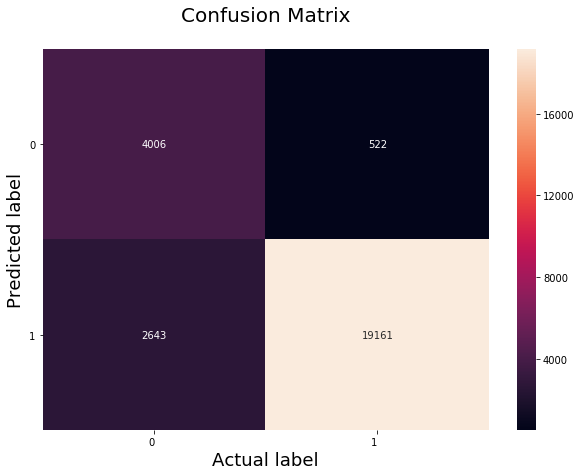

In [214]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_tfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()

In [216]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_tfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TPR))
print("FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FPR))
print("TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TNR))
print("FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FNR))

TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.973480
FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.397503
TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.602497
FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.026520


# ROC CURVE FOR TFIDF 

In [217]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs3)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [218]:
from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs2)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    

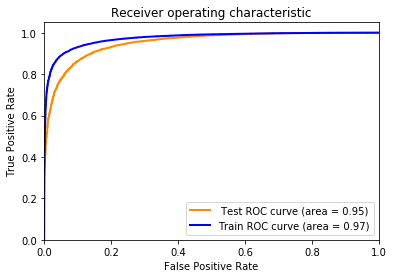

In [219]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations: 
1) We found that the model has been good as test score is 0.95.

In [221]:
from IPython.display import HTML, display
import tabulate
table = [["Vectorizer","Model","Regularisation","Hyperparameter","AUC"],
         ["TFIDF", "Logistic Regression ", "L2 " , 1, np.round(auc_tfidf,4) ]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Vectorizer,Model,Regularisation,Hyperparameter,AUC
TFIDF,Logistic Regression,L2,1,0.9476


# Word 2 Vector Data

# Preparaing Training Data for Word to Vector 

In [81]:
i=0
list_of_sentance=[]
for sentance in (X_trainbow['Cleaned Text'].values):
    list_of_sentance.append(sentance.split())

In [82]:
#WORD TO VECTOR

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('awesome', 0.837866485118866), ('fantastic', 0.8337129950523376), ('good', 0.8291321992874146), ('terrific', 0.8278248310089111), ('excellent', 0.8037208914756775), ('amazing', 0.7729521989822388), ('wonderful', 0.7634998559951782), ('perfect', 0.7406936883926392), ('fabulous', 0.7048882246017456), ('nice', 0.6872305870056152)]
[('greatest', 0.7341300249099731), ('best', 0.718138575553894), ('tastiest', 0.6966129541397095), ('coolest', 0.6698259115219116), ('softest', 0.6337562203407288), ('experienced', 0.6275156736373901), ('disgusting', 0.6122303009033203), ('hardly', 0.6104421615600586), ('sweetest', 0.6094722151756287), ('healthiest', 0.6028370261192322)]
number of words that occured minimum 5 times  14706
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regard

In [83]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [02:58<00:00, 344.80it/s]


61441
50


In [84]:
sent_vectors[1]

array([ 0.04890214, -0.14278135, -1.10542209, -0.99986619,  1.0820545 ,
       -0.56911343, -0.004523  ,  0.07691254,  0.50313495, -0.38799589,
        0.68416539,  0.52483384,  0.96414184, -0.19560302, -0.59333614,
       -0.46169094, -0.54413816,  0.31657766, -0.75484315, -0.55712079,
       -0.89080958, -0.31800228,  0.50076959, -0.88002695,  0.56853789,
       -0.03655677,  0.49549705, -0.49388191, -0.00710877,  0.07185667,
        0.55003923,  0.42068573,  0.33435393, -0.44359435, -0.84809294,
        0.10629431, -0.07982829, -1.04015905, -0.38349784, -0.08395805,
        0.37014867,  0.33803843, -0.34764388,  0.19936448,  0.41075423,
        0.42167061, -0.54079796,  0.89475422,  0.43667886, -0.40579795])

# Preparing Test Data for Word to Vector 

In [98]:
X_test1.head(4)

,Cleaned Text,Length
61441,used treat training reward dog loves easy brea...,66
61442,much fun watching puppies asking chicken treat...,134
61443,little shih tzu absolutely loves cesar softies...,181
61444,westie like picture package loves treats perfe...,162


In [85]:
i=0
list_of_sentance1=[]
for sentance in (X_test1['Cleaned Text'].values):
    list_of_sentance1.append(sentance.split())

In [86]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model1=Word2Vec(list_of_sentance1,min_count=5,size=50, workers=4)
    print(w2v_model1.wv.most_similar('great'))
    print('='*50)
    print(w2v_model1.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model1=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model1.wv.most_similar('great'))
        print(w2v_model1.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
print("sample words ", w2v_words1[0:50])

[('awesome', 0.8288255929946899), ('fantastic', 0.809904158115387), ('excellent', 0.808659017086029), ('good', 0.7877645492553711), ('wonderful', 0.785922646522522), ('amazing', 0.7437194585800171), ('perfect', 0.7215654850006104), ('nice', 0.6872482299804688), ('decent', 0.6802107095718384), ('especially', 0.6469941139221191)]
[('greatest', 0.7991249561309814), ('closest', 0.7835322022438049), ('best', 0.7637677192687988), ('nastiest', 0.7435516715049744), ('ever', 0.7076125144958496), ('hottest', 0.684563398361206), ('tastiest', 0.6682063341140747), ('disgusting', 0.6582975387573242), ('honestly', 0.6542456746101379), ('smoothest', 0.6514889001846313)]
number of words that occured minimum 5 times  9573
sample words  ['used', 'treat', 'training', 'reward', 'dog', 'loves', 'easy', 'break', 'smaller', 'pieces', 'buy', 'much', 'fun', 'watching', 'puppies', 'asking', 'chicken', 'treats', 'go', 'crazy', 'show', 'blue', 'package', 'small', 'eat', 'not', 'bad', 'smell', 'recommend', 'happy',

In [87]:
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:57<00:00, 456.00it/s]


26332
50


In [88]:
e3 = sent_vectors
f3 = sent_vectors1

In [89]:
len(y_test1)

26332

In [90]:
e3 = preprocessing.normalize(e3)
e4 = sparse.csr_matrix(X_train1['Length'].values)
e4 = preprocessing.normalize(e4)
e5 = sparse.hstack([e3, e4.T])

In [91]:
f3 = preprocessing.normalize(f3)
f4 = sparse.csr_matrix(X_test1['Length'].values)
f4 = preprocessing.normalize(f4)
f5 = sparse.hstack([f3, f4.T])

# Applying Logistic Regression on Word to VECTOR 

# L1 REGULARISATION  (with out feature engineering)

In [136]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
#tuned_parameters = [{'C': [10**0, 10**2, 10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model1 = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv= 10 , return_train_score = True)
model1.fit(e3, y_train1)
print(model1.best_estimator_)
print(model1.score(f3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8323192696350981


# L1 REGULARISATION (with feature engineering)

In [137]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
#tuned_parameters = [{'C': [10**0, 10**2, 10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model2 = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv= 10, return_train_score = True)
model2.fit(e5, y_train1)
print(model2.best_estimator_)
print(model2.score(f5, y_test1))

LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8300318858244313


# L2 REGULARISATION (with out feature engineering)

In [138]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
#tuned_parameters = [{'C': [10**0, 10**2, 10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model3 = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv= 10, return_train_score = True)
model3.fit(e3, y_train1)
print(model3.best_estimator_)
print(model3.score(f3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8340502994717474


# L2 REGULARISATION ( with feature engineering )

In [139]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
#tuned_parameters = [{'C': [10**0, 10**2, 10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model4 = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv= 10, return_train_score = True)
model4.fit(e5, y_train1)
print(model4.best_estimator_)
print(model4.score(f5, y_test1))

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8306388432148152


# Observations:

1) We found that there is a difference of 2% in the ROC_AUC value when applied with feature engineering in both regularisations.

2) However L2 regularisation performed marginally better when compared to L1 regularisation. 

3) Finallly L2 regularisation with feature engineering is the better model among the 4. 

In [140]:
model_w2v = model3

# Finding Optimal Hyper parameter through plotting approach

In [141]:
model3.cv_results_

{'mean_fit_time': array([0.1204649 , 0.13902953, 0.33884156, 0.63425193, 0.63269374,
        0.64831564, 0.64050553]),
 'std_fit_time': array([0.01294119, 0.01093562, 0.01214535, 0.01430981, 0.01881007,
        0.01881102, 0.0156204 ]),
 'mean_score_time': array([0.00176158, 0.0062485 , 0.00156212, 0.        , 0.00155902,
        0.        , 0.00468192]),
 'std_score_time': array([0.00465799, 0.00765282, 0.00468636, 0.        , 0.00467706,
        0.        , 0.00715176]),
 'param_C': masked_array(data=[1e-05, 0.0001, 0.01, 1, 100, 10000, 100000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.01},
  {'C': 1},
  {'C': 100},
  {'C': 10000},
  {'C': 100000}],
 'split0_test_score': array([0.87981604, 0.88286926, 0.90258058, 0.90627662, 0.90617388,
        0.90617128, 0.90617148]),
 'split1_test_score': array([0.88241853, 0.88570041, 0.9071761 , 0.91290576, 0.9130

In [142]:
train_auc_w2v = model3.cv_results_['mean_train_score']
cv_auc_w2v = model3.cv_results_['mean_test_score']

In [143]:
alph1 = [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]

In [144]:
train_auc_w2v

array([0.8725477 , 0.87597682, 0.89881314, 0.90377082, 0.90379606,
       0.90379601, 0.90379601])

In [145]:
cv_auc_w2v

array([0.8719251 , 0.87535048, 0.89796719, 0.90219481, 0.90215969,
       0.90215871, 0.90215873])

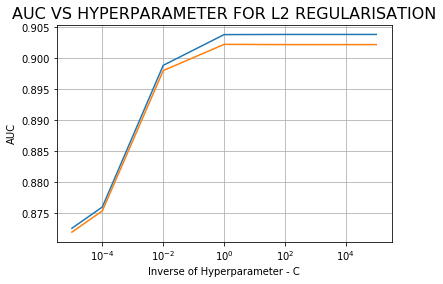



 Alpha values :
 [1e-05, 0.0001, 0.01, 1, 100, 10000, 100000]

 Train AUC for each alpha value is :
  [0.87255 0.87598 0.89881 0.90377 0.9038  0.9038  0.9038 ]

 CV AUC for each alpha value is :
  [0.87193 0.87535 0.89797 0.90219 0.90216 0.90216 0.90216]


In [146]:
plt.plot(alph1,train_auc_w2v)
plt.plot(alph1,cv_auc_w2v)
plt.xlabel('Inverse of Hyperparameter - C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER FOR L2 REGULARISATION',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha values :\n", alph1)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc_w2v,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc_w2v,5))

# Observations:

1) This is a shock to me. Despite trying many times, I have found that there is a similarity between train and cv AUC'S.

2) However I have chosen the optimal C to be 1 . 

# Running the model with the optimal hyperparameter 

In [148]:
om_w2v = LogisticRegression(C = 1 , penalty = 'l2' , class_weight = 'balanced')
om_w2v.fit(e3, y_train1)
ompredictions_w2v  = om_w2v.predict(f3)
probs4 = om_w2v.predict_proba(e3)
probs5 = om_w2v.predict_proba(f3)
probs4= probs4[:, 1]
probs5 = probs5[:, 1]

# PERFORMANCE MEASURMENTS FOR w2v Logistic Regression 

In [149]:
precision_w2v = precision_score(y_test1, ompredictions_w2v, pos_label = 1) 
recall_w2v = recall_score(y_test1, ompredictions_w2v, pos_label = 1) 
f1score_w2v = f1_score(y_test1, ompredictions_w2v, pos_label = 1) 

print('\nThe Test Precision for optimal c for LR (TFIDF) is %f' % (precision_w2v))
print('\nThe Test Recall for optimal c for LR (TFIDF) is  %f' % (recall_w2v))
print('\nThe Test F1-Score for optimal c for LR (TFIDF) is  %f' % (f1score_w2v))


The Test Precision for optimal c for LR (TFIDF) is 0.875116

The Test Recall for optimal c for LR (TFIDF) is  0.954183

The Test F1-Score for optimal c for LR (TFIDF) is  0.912940


Text(0.5,1,'Confusion Matrix\n')

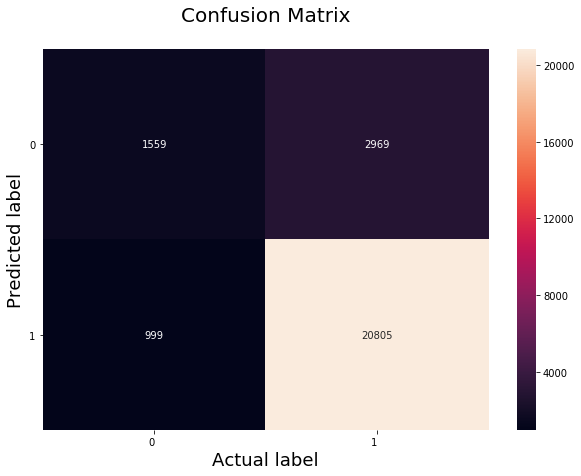

In [150]:
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_w2v), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

In [153]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_w2v).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Logistic Regression  (TFIDF) for optimal alpha   is :  %f" % (TPR))
print("FPR of the Logistic Regression (TFIDF) for optimal  alpha  is :  %f" % (FPR))
print("TNR of the Logistic Regression (TFIDF) for optimal alpha  is :  %f" % (TNR))
print("FNR of the Logistic Regression (TFIDF) for optimal alpha  is :  %f" % (FNR))

TPR of the Logistic Regression  (TFIDF) for optimal alpha   is :  0.875116
FPR of the Logistic Regression (TFIDF) for optimal  alpha  is :  0.390539
TNR of the Logistic Regression (TFIDF) for optimal alpha  is :  0.609461
FNR of the Logistic Regression (TFIDF) for optimal alpha  is :  0.124884


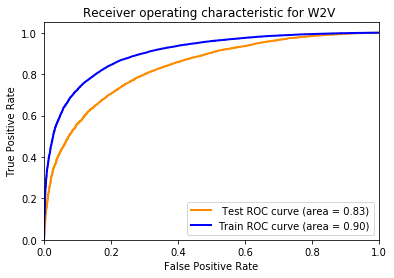

In [155]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs5)
    roc_auc[i] = auc(fpr[i], tpr[i])


from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs4)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic for W2V ')
plt.show()

# Observations :

1) Word 2 vECTOR HAS NOT PERFORMED THAT EFFICIENTLY WHEN COMPARED TO BOW or TFIDF.

2) Test Acuuracy is very less when compared to train accuracy. Hence Overfitting would have been the issue here.

# TFIDF AVERGE WORD TO VECTOR 

# Preparing Training Data for TFIDF-AVG W2V

In [92]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_trainbow['Cleaned Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [93]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [30:36<00:00, 33.46it/s]


# Preparing Test Data for TFIDF- AVG W2V

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1 and word in tfidf_feat:
            vec = w2v_model1.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [11:56<00:00, 36.75it/s]


In [96]:
g3 = tfidf_sent_vectors
h3 = tfidf_sent_vectors1

In [97]:
g3 = preprocessing.normalize(g3)
h3 = preprocessing.normalize(h3)

# LOGISTIC REGRESSION ON TFIDF - AVG W2V 

# CHECKING SPARSITY ON L1 REGURALISATION - LR

In [99]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(g3,y_train1)
y_pred = clf.predict(h3)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test1, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test1, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 83.332%
F1-Score on test set: 0.833
Non Zero weights: 20


In [100]:
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(g3,y_train1)
y_pred = clf.predict(h3)
#print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
#print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 38


In [101]:
clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(g3,y_train1)
y_pred = clf.predict(h3)
#print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
#print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 49


In [102]:
clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(g3,y_train1)
y_pred = clf.predict(h3)
#print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
#print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 50


In [103]:
clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(g3,y_train1)
y_pred = clf.predict(h3)
#print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
#print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 50


# OBSERVATIONS :

1) As lamda value increases the count of non zero value decreases for l1 regularisation.

In [104]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
#tuned_parameters = [{'C': [10**0, 10**2, 10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model1 = GridSearchCV(LogisticRegression(penalty='l2', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv= 10 , return_train_score = True)
model1.fit(g3, y_train1)
print(model1.best_estimator_)
print(model1.score(h3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.7784120558810812


In [105]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
#tuned_parameters = [{'C': [10**0, 10**2, 10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model2 = GridSearchCV(LogisticRegression(penalty='l1', class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', cv= 10 , return_train_score = True)
model2.fit(g3, y_train1)
print(model2.best_estimator_)
print(model2.score(h3, y_test1))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.7772799715648505


# Running the model with the optimal c - tfidf-avgw2v

In [106]:
om_w2vtfidf = LogisticRegression(C = 1 , penalty = 'l2' , class_weight = 'balanced')
om_w2vtfidf.fit(g3, y_train1)
ompredictions_w2vtfidf  = om_w2vtfidf.predict(h3)

In [107]:
probs6 = om_w2vtfidf.predict_proba(g3)
probs7 = om_w2vtfidf.predict_proba(h3)
probs6= probs6[:, 1]
probs7 = probs7[:, 1]

In [108]:
precision_w2vtfidf = precision_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 
recall_w2vtfidf = recall_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 
f1score_w2vtfidf = f1_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 

In [109]:
print('\nThe Test Precision for optimal c for LR (TFIDF) is %f' % (precision_w2vtfidf))
print('\nThe Test Recall for optimal c for LR (TFIDF) is  %f' % (recall_w2vtfidf))
print('\nThe Test F1-Score for optimal c for LR (TFIDF) is  %f' % (f1score_w2vtfidf))


The Test Precision for optimal c for LR (TFIDF) is 0.902072

The Test Recall for optimal c for LR (TFIDF) is  0.788754

The Test F1-Score for optimal c for LR (TFIDF) is  0.841616


Text(0.5,1,'Confusion Matrix\n')

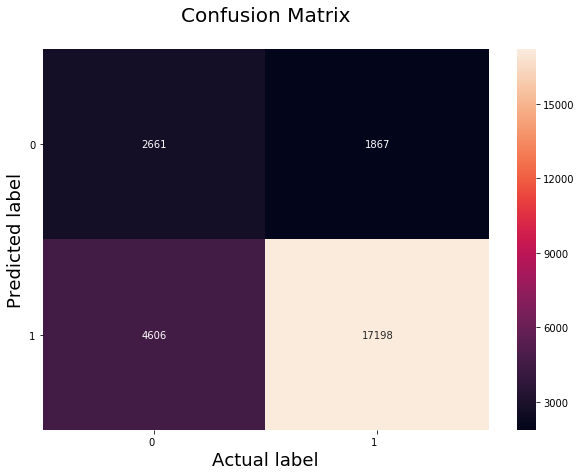

In [110]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_w2vtfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

In [111]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_w2vtfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TPR))
print("FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FPR))
print("TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TNR))
print("FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FNR))

TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.902072
FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.633824
TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.366176
FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.097928


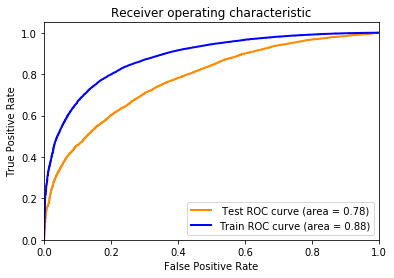

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs7)
    roc_auc[i] = auc(fpr[i], tpr[i])


from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs6)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations 

1) Both Training Accuracy and Test acccuracy has been very low in TFIDF- AVG W2V. 
  The reason might be the case that I did not take feature engineering for this vectoriser and the model may be over fitted.


# Conclusions

In [95]:
res = pd.DataFrame()

In [115]:
model_names = ["BOW","BOW","TF-IDF","TF-IDF","W2V","W2V","W2V","W2V", "TF-IDF AVGW2V" , "TF-IDF AVGW2V"]
Hyperparameter = [1,1,1,1,1,10000,1,100,1,1]
s3 = "L1"
s4 = "L2"
Regularisation = [s3,s4,s3,s4,s3,s3,s4,s4,s3,s4]
s1 = "YES"
s2 = "NO"
Feature_Engineering = [s1,s1,s1,s1,s2,s1,s2,s1,s2,s2]
AUC = [0.9448,0.9439,0.9509,0.9516,0.8323,0.8300,0.8341,0.8306,0.7772,0.7784]

In [116]:
res['Vectorizer'] = model_names
res['Hyper Parameter'] =  Hyperparameter 
res['Regularisation'] = Regularisation 
res['Feature Engineering'] = Feature_Engineering  
res['AUC'] = AUC

In [117]:
res

,Vectorizer,Hyper Parameter,Regularisation,Feature Engineering,AUC
0,BOW,1,L1,YES,0.9448
1,BOW,1,L2,YES,0.9439
2,TF-IDF,1,L1,YES,0.9509
3,TF-IDF,1,L2,YES,0.9516
4,W2V,1,L1,NO,0.8323
5,W2V,10000,L1,YES,0.8300
6,W2V,1,L2,NO,0.8341
7,W2V,100,L2,YES,0.8306
8,TF-IDF AVGW2V,1,L1,NO,0.7772
9,TF-IDF AVGW2V,1,L2,NO,0.7784


In [119]:
import tabulatehelper as th

# DISPLAYING THE RESULTS IN TABULAR FORMAT 

In [120]:
print(th.md_table(res, formats={-1: 'c'}))

| Vectorizer    |   Hyper Parameter | Regularisation   | Feature Engineering   |    AUC |
|:--------------|------------------:|:-----------------|:----------------------|:------:|
| BOW           |                 1 | L1               | YES                   | 0.9448 |
| BOW           |                 1 | L2               | YES                   | 0.9439 |
| TF-IDF        |                 1 | L1               | YES                   | 0.9509 |
| TF-IDF        |                 1 | L2               | YES                   | 0.9516 |
| W2V           |                 1 | L1               | NO                    | 0.8323 |
| W2V           |             10000 | L1               | YES                   | 0.83   |
| W2V           |                 1 | L2               | NO                    | 0.8341 |
| W2V           |               100 | L2               | YES                   | 0.8306 |
| TF-IDF AVGW2V |                 1 | L1               | NO                    | 0.7772 |
| TF-IDF A

# Final Observations :


1) The best models have come through BOW and TFIDF. In TFIDF the AUC has been slightly higher when compared to BOW. Hence TFIDF WITH FEATURE ENGINEERING AND WITH L2 REGULARISATION IS THE BEST MODEL FOR THIS CASE.

2) IN THE CASE OF BAG OF WORDS, L1 REGULARISATION PERFORMED MARGINALLY BETTER WHEN COMPARED TO L2 REGULARISATION.

3) IN THE CASE OF TFIDF , L2 REGULARISATION PERFORMED MARGINALLY BETTER WHEN COMPARED TO L1 REGULARISATION.

4) IN THE CASE OF W2V, MODEL WITH OUT FEATURE ENGINEERING PERFORMED BETTER THAN THE ONE WITH FEATURE ENGINEERING. BY REGULARISION WISE L2 PERFORMED BETTER THAN L1 IN AVG-W2V. HOWEVER THE AUC VALUE OVERALL IS VERY LESS COMPARED TO THAT OF BOW  OR TFIDF

5) IN THE CASE OF TFIDF- AVG W2V, I HAVE NOT USED FEATURE ENGINEERING. HOWEVER IN THIS CASE TOO, THE L2 REGULARISATION PERFORMED 
  MARGINALLY BETTER WHEN COMPARED TO L1

6) As suggested I have added length of preprocessed reviews as one more feature which has been contributed for more accuracy. 
   However if i would have used more features like length of common words or something else, the results would have been 
   different( my assumption)

7) I have checked the sparsity for tfidf-avgw2v. As the c value increase the count of non zero value too increases for l1 regularisation.


8) I have checked the pertubation test to know whether the features are collinear or not. I have discovered that there is no big change in the coefficients ( with noise and with out noise). Through elbow method I have fixed the threshold percentage as 2%. THere are very few features that are collinear.



# References 

I have referred many links. However part of my code has been inspired from the following links 

1) Applied AI Course  - https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/

2) GITHUB - PushpendraSinghChauhan (#https://github.com/PushpendraSinghChauhan/Amazon-Fine-FoodReviews/blob/master/Apply%20Naive%20Bayes%20on%20Amazon%20Fine%20Food%20Reviews.ipynb)

3) SKLEARN 

4) STACK OVERFLOW  - MANY 